### Stress and Toughness Plots

Plots are located at the bottom of this notebook, all prior cells are intermediate data processing steps.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy.integrate import simpson
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import statsmodels as sm

In [2]:
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}

save_folder = 'Data/Stress_Toughness_Notebook_Saves/'

In [3]:
if not os.path.exists(save_folder):
    # The folder does not exist, so create it
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' was created.")
else:
    # The folder exists, so do nothing
    print('folder already exists!')

folder already exists!


In [4]:
def find_upper_yield_strength(data, prominence_factor=.01, drop_threshold=0.05):
    # Calculate the prominence based on the maximum stress observed
    prominence = data['stress'].max() * prominence_factor
    
    # Identify peaks in the stress data
    peaks, _ = find_peaks(data['stress'], prominence=prominence, threshold=drop_threshold)
    
    for peak in peaks:
        peak_stress = data.iloc[peak]['stress']
        # Search for a significant drop within the next few data points
        for i in range(peak+1, len(data)):
            if data.iloc[i]['stress'] <= peak_stress * (1 - drop_threshold):
                # Found a substantial failure
                return data.iloc[peak]['stress'], data.iloc[peak]['strain']
    
    return None, None  # In case no substantial failure is found

def find_all_relevant_peaks(data, prominence_factor=0.01):
    # Calculate the prominence based on the maximum stress observed
    prominence = data['stress'].max() * prominence_factor
    
    # Identify peaks in the stress data
    peaks, _ = find_peaks(data['stress'], prominence=prominence)
    
    # Use list comprehension to create a list of tuples with stress and strain values for each peak
    return [(data.iloc[peak]['stress'], data.iloc[peak]['strain']) for peak in peaks]

def extract_run_number(folder_name):
    """Extract the numerical part of the test run from the folder name."""
    match = re.search(r'Test Run (\d+)', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None  # In case the folder name does not match the expected format

In [5]:
# Original length in m
L0 = 36.0 * 10**-3

# Cross-sectional area in square m (30mm x 30mm)
area = 30*(10**-3) * 30*(10**-3)

# Set your main directory here
main_folder_path = 'Data/MTS_Runs/'

# List all subdirectories in the main directory
subfolders = [os.path.join(main_folder_path, f.name) for f in os.scandir(main_folder_path) if f.is_dir()]

# Filter and sort the subfolders based on the run number
filtered_subfolders = []
for folder in subfolders:
    run_number = extract_run_number(os.path.basename(folder))
    if run_number:
        filtered_subfolders.append((folder, run_number))

In [6]:
# Sort the folders based on the extracted run number
filtered_subfolders.sort(key=lambda x: x[1])

# Initialize a list to store the toughness and peak counts for each run
toughness_and_peak_counts = []
strengths = []
# Assuming you want to dynamically generate combinations for demonstration
# Adjust these ranges as necessary to fit your actual criteria
prominence_factors = np.linspace(0.01, .25, 1000)  # Adjust the start, stop, and num values

# Ensure we have 50 combinations
assert len(prominence_factors) >= 50, "Not enough combinations"

# Now process each filtered and sorted folder
for folder, run_number in filtered_subfolders:
    # Construct the file path
    file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    
    # Check if the file exists before trying to read it
    if os.path.isfile(file_path):
        # Read the data
        data = pd.read_csv(file_path, sep='\t', skiprows=7)
        
        # Calculate strain and stress
        data['strain'] = data['mm'] * (10**-3) / L0
        data['stress'] = (data['kN'] * 1000) / area

        # Calculate toughness using Simpson's rule for numerical integration
        toughness = simpson(y=data['stress'], x=data['strain'])


        relevant_peaks_dict = {}
        peak_counts = []
        for prom in prominence_factors:
            relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
            num_peaks = len(relevant_peaks)
            peak_counts.append(num_peaks)
            relevant_peaks_dict[(prom)] = relevant_peaks

        # Append both toughness and the count of fracture peaks for all criteria
        toughness_and_peak_counts.append([run_number, toughness] + peak_counts)

        # Find the first and second derivate of the stress/ strain.
        first_derivative = savgol_filter(np.gradient(data['stress'], data['strain']), window_length=51, polyorder=3)
        second_derivative = savgol_filter(np.gradient(first_derivative, data['strain']), window_length=51, polyorder=3)
        original_strain = data['strain']  # Your original strain data
        min_strain, max_strain = np.min(original_strain), np.max(original_strain)
        interp_strain = np.linspace(min_strain, max_strain, len(original_strain) * 1000)
        interp_second_derivative = np.interp(interp_strain, original_strain, second_derivative)
        interp_first_derivative = np.interp(interp_strain, original_strain, first_derivative)
    
        linear_start_indices = np.where((interp_second_derivative < np.std(interp_second_derivative)*.1) & (interp_second_derivative > 0) & (interp_first_derivative > (max(interp_first_derivative)/10)))[0]
        linear_start_index = round((min(linear_start_indices))/1000)
        # print('linear start index:',linear_start_index)

# Slope at the linear start index from the smoothed_derivative (first derivative of stress)
        slope_at_start = first_derivative[linear_start_index]

        line_start_stress = data['stress'][linear_start_index] - slope_at_start * data['strain'][linear_start_index]
        linear_stress = line_start_stress + slope_at_start * data['strain']
        offset_strain = data['strain'] + 0.002

        # Calculate the y-intercept of the imaginary line using the linear start point
        for i in range(0,linear_start_index):
            strain = data['strain'][i]
            stress = data['stress'][i]
            if  linear_stress[i]  >= 0:
                y_intercept = strain
                y_intercept_index=i
                # print("y_int_index:",y_intercept_index)
                break

        # Find the intersection point by comparing the stress of the imaginary line and the actual curve
        for i in range(linear_start_index, len(data['stress'])):
            if linear_stress[i] >= data['stress'][i+5]:
                yield_point_index = i+5
                break

        plt.figure(figsize=(10, 6))

        # Toe region in yellow
        plt.plot(data['strain'][:linear_start_index], data['stress'][:linear_start_index], color='orange', label='Toe Region')

        # Linear region in blue
        plt.plot(data['strain'][linear_start_index:yield_point_index], data['stress'][linear_start_index:yield_point_index], color='blue', label='Linear Region')

        # Plastic region in green
        plt.plot(data['strain'][yield_point_index:], data['stress'][yield_point_index:], color='green', label='Plastic Region')
        r2s=data['stress'][yield_point_index] #defining R.2% Yield Strength
        # Mark all peaks
        for stress, strain in relevant_peaks_dict[(prominence_factors[0])]:
            plt.plot(strain, stress, 'rx', markersize=5, label='Small Peaks' if 'Small Peaks' not in plt.gca().get_legend_handles_labels()[1] else "")

        # Plotting large peaks with blue Os (open circles)
        for stress, strain in relevant_peaks_dict[(prominence_factors[-1])]:
            plt.plot(strain, stress, 'bo', markersize=10, mec='b', mfc='none', label='Large Peaks' if 'Large Peaks' not in plt.gca().get_legend_handles_labels()[1] else "")

# Adjusting p
        # plt.axvline(x=data['strain'][linear_start_index], color='black', linestyle='--', label='Start of Elastic Region')
        plt.plot(offset_strain[y_intercept_index:yield_point_index -5], linear_stress[y_intercept_index:yield_point_index -5],  linestyle='--', label='R_.2', color='cyan')

        # print("R_0.2 Yeild Index:", yield_point_index)
        plt.axvline(x=data['strain'][yield_point_index], color='violet', linestyle='--', label='R.2 Yield Strength')
        # print('strain array length:', len(data['strain']))

        upper_yield_strength, upper_yield_strain = find_upper_yield_strength(data)
        if upper_yield_strength is not None:
            # print(f"Upper yield strength found: {upper_yield_strength} at strain {upper_yield_strain}")
            upper_yield_strength_indices = np.where((data['strain'] > (upper_yield_strain - .001)) & (data['strain'] < (upper_yield_strain + .001)))[0]
            upper_yield_strength_index = min(upper_yield_strength_indices) if upper_yield_strength_indices.size > 0 else None

            if upper_yield_strength_index is not None:
                # print(f"Upper Yield Strength index: {upper_yield_strength_index}")
                plt.axvline(x=data['strain'][upper_yield_strength_index], color='red', linestyle='--', label='UYS')
                uys = upper_yield_strength #defining upper yield strength
            else:
                print("No index found matching the condition.")
                uys = "N/A"

            # print(upper_yield_strength_index)
        strengths.append([run_number,uys,r2s])
        plt.title(f'Stress vs. Strain for Run {run_number}')
        plt.xlabel('Compressive Engineering Strain')
        plt.ylabel('Stress (Pa)')
        plt.legend()
        # plt.grid(True)
        plt.savefig(os.path.join(save_folder, f'stress_vs_strain_regions_run_{run_number}.png'))
        plt.close()
print('done')


done


In [7]:
# Generate column names for the fracture peak counts dynamically
peak_count_columns = [f'Peaks_Prom_{prom:.3f}' for prom in prominence_factors]
column_names = ['Run Number', 'Toughness'] + peak_count_columns

# After processing all folders, compile toughness data into a DataFrame
toughness_df = pd.DataFrame(toughness_and_peak_counts, columns=column_names)

# Assuming 'sample_data' is already defined
sample_data_df = pd.DataFrame(sample_data)

column_names = ['Run Number', 'UYS', 'R.2%S'] 
strengths_df = pd.DataFrame(strengths, columns=column_names)

# Convert 'CID' to numeric, coercing 'N/A' to NaN
sample_data_df['CID'] = pd.to_numeric(sample_data_df['CID'], errors='coerce')

# Merge the DataFrames on 'Run Number'
merged_df_2 = pd.merge(toughness_df, sample_data_df, on='Run Number', how='inner')
merged_df_2 = pd.merge(merged_df_2, strengths_df, on='Run Number', how='inner')

merged_df_2.to_csv(os.path.join(save_folder, 'toughness_and_peaks_2.csv'), index=False)
# print(merged_df_2)
merged_df_bk=merged_df_2 

print('Toughness values, number of peaks, and plots saved. Job done.')


Toughness values, number of peaks, and plots saved. Job done.


In [8]:
import pandas as pd

# Assuming 'merged_df' and necessary columns exist as per your setup
merged_df_bk=merged_df_bk
merged_df_2=merged_df_bk
# Calculate initial Net Mass for all samples
merged_df_2['Net Mass'] = 1.25 * merged_df_2['Voxel Count'] * (1/1000) * (100**3) * (10**-3)**3

# Identify samples with 'ADF360' in their names and calculate a different Net Mass
# Set `na=False` to treat NaN values in 'Sample Name' as not containing 'ADF360'
mask = merged_df_2['Sample Name'].str.contains("ADF360", na=False)
merged_df_2.loc[mask, 'Net Mass'] = 1.25 * (1/1000) * (100**3) * (merged_df_2.loc[mask, 'Voxel Count'] - (2*30*30*3)) * (10**-3)**3

# Calculate Effective Density using the updated Net Mass
merged_df_2['Effective Density'] = merged_df_2['Net Mass'] / (30 * 10**-3)**3

# Calculate Specific UYS and Specific R2S using the updated Effective Density
merged_df_2['Specific UYS'] = merged_df_2['UYS'] / merged_df_2['Effective Density']
merged_df_2['Specific R2S'] = merged_df_2['R.2%S'] / merged_df_2['Effective Density']
merged_df_2['Specific Toughness'] = merged_df_2['Toughness'] / merged_df_2['Effective Density']



/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_27341/539489441.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UYS'] /= 1e3
/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_27341/539489441.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R.2%S'] /= 1e3
/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_27341/539489441.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

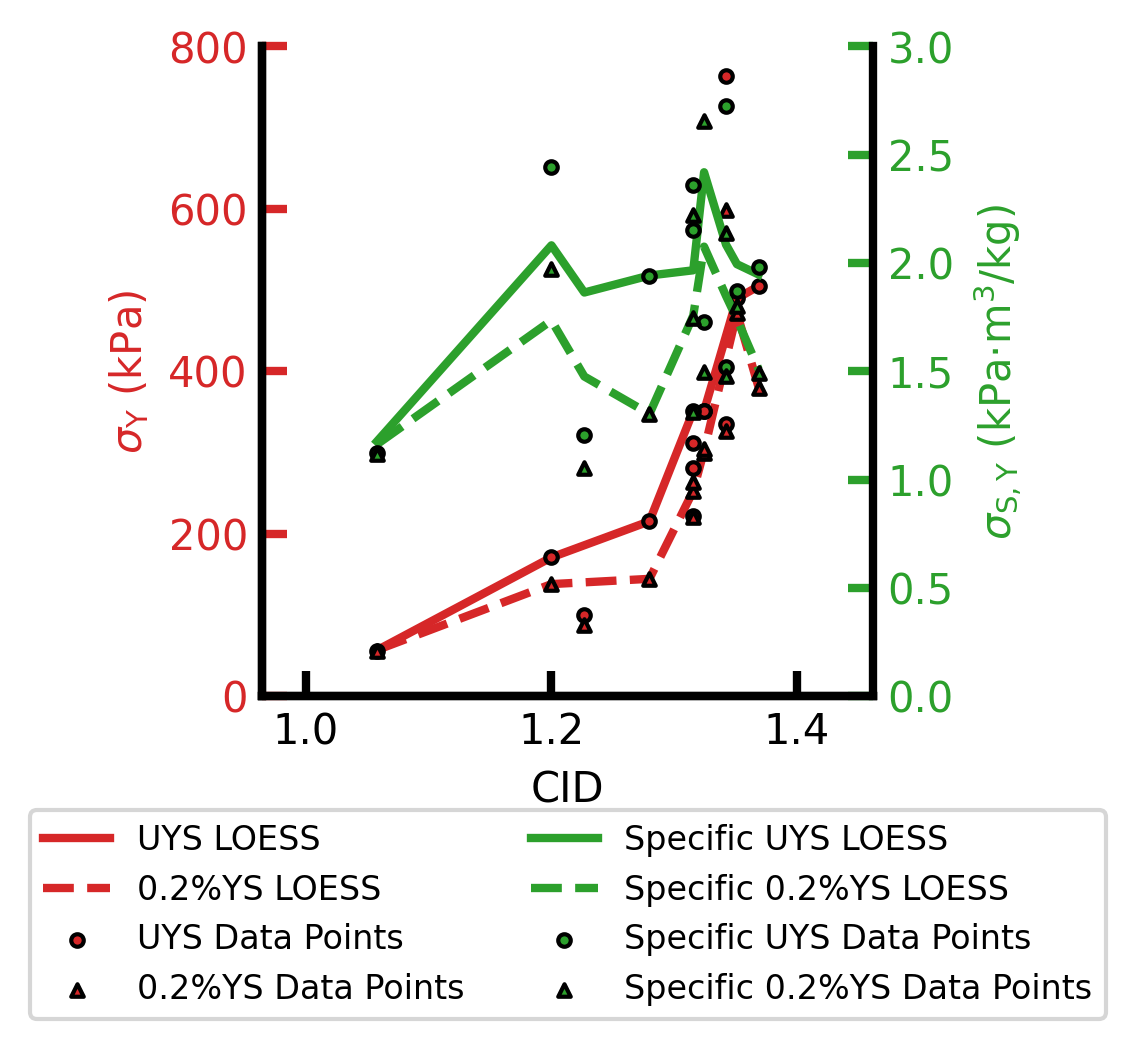

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

size = 9

def plot_dual_y_axes(df):
    # Convert values from Pa to kPa and from Pa to m²/s² respectively if necessary
    if df['UYS'].max() > 1000:
        df['UYS'] /= 1e3
    if df['R.2%S'].max() > 1000:
        df['R.2%S'] /= 1e3
    if df['Specific UYS'].max() > 1000:
        df['Specific UYS'] /= 1e3
    if df['Specific R2S'].max() > 1000:
        df['Specific R2S'] /= 1e3

    # Create a single plot
    fig, ax1 = plt.subplots(figsize=(3.35, 3.7), dpi=300)
    ax2 = ax1.twinx()

    # LOESS smoothing
    frac = 0.5  # Fraction of data used for LOESS

    lowess = sm.nonparametric.lowess
    loess_uys = lowess(df['UYS'], df['CID'], frac=frac)
    loess_r2s = lowess(df['R.2%S'], df['CID'], frac=frac)
    loess_specific_uys = lowess(df['Specific UYS'], df['CID'], frac=frac)
    loess_specific_r2s = lowess(df['Specific R2S'], df['CID'], frac=frac)

    # Plot UYS and 0.2% Offset Yield Strength on the primary y-axis
    ax1.plot(loess_uys[:, 0], loess_uys[:, 1], color='#d62728', label='UYS LOESS', lw=2, zorder=1)
    ax1.plot(loess_r2s[:, 0], loess_r2s[:, 1], color='#d62728', linestyle='--', label='0.2%YS LOESS', lw=2, zorder=1)
    ax1.scatter(df['CID'], df['UYS'], s=size, edgecolor='black', facecolor='#d62728', marker='o', label='UYS Data Points', zorder=2)
    ax1.scatter(df['CID'], df['R.2%S'], s=size, edgecolor='black', facecolor='#d62728', marker='^', label='0.2%YS Data Points', zorder=2)

    # Plot Specific UYS and Specific 0.2% Offset Yield Strength on the secondary y-axis
    ax2.plot(loess_specific_uys[:, 0], loess_specific_uys[:, 1], color='#2ca02c', label='Specific UYS LOESS', lw=2, zorder=3)
    ax2.plot(loess_specific_r2s[:, 0], loess_specific_r2s[:, 1], color='#2ca02c', linestyle='--', label='Specific 0.2%YS LOESS', lw=2, zorder=3)
    ax2.scatter(df['CID'], df['Specific UYS'], s=size, edgecolor='black', facecolor='#2ca02c', marker='o', label='Specific UYS Data Points', zorder=4)
    ax2.scatter(df['CID'], df['Specific R2S'], s=size, edgecolor='black', facecolor='#2ca02c', marker='^', label='Specific 0.2%YS Data Points', zorder=4)

    # Set the colors of the y-axes
    ax1.yaxis.label.set_color('#d62728')
    ax2.yaxis.label.set_color('#2ca02c')
    ax1.tick_params(axis='y', colors='#d62728', labelsize=10, direction='in', length=6, width=2)
    ax2.tick_params(axis='y', colors='#2ca02c', labelsize=10, direction='in', length=6, width=2)

    # Set y-axis labels
    ax1.set_ylabel(r"$\sigma_{\mathrm{Y}}$ (kPa)", color='#d62728', fontsize=10)
    ax2.set_ylabel(r"$\sigma_{\mathrm{S,Y}}$ (kPa$\cdot$m$^3$/kg)", color='#2ca02c', fontsize=10)

    # Set x-axis label and add tick marks
    ax1.set_xlabel("CID", fontsize=10)
    ax1.tick_params(axis='x', labelsize=10, bottom=True, top=False, direction='in', length=6, width=2)

    # Remove the top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(True)

    # Keep only the left and bottom spines and set the border color to black
    for spine in ['left', 'right', 'bottom']:
        ax1.spines[spine].set_edgecolor('black')
        ax1.spines[spine].set_linewidth(2)
        ax2.spines[spine].set_edgecolor('black')
        ax2.spines[spine].set_linewidth(2)

    # Combine the legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8)

    # Remove grid lines
    ax1.grid(False)
    ax2.grid(False)

    # Adjust the x-axis limits to provide some buffer
    x_min = df['CID'].min()
    x_max = df['CID'].max()
    x_range = x_max - x_min
    x_buffer = 0.30 * x_range
    ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax2.set_ylim(0, 3)
    ax1.set_ylim(0, 800)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage
plot_dual_y_axes(merged_df_2[:13])


/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_27341/3229942463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Toughness'] = df['Toughness'] / 1e3
/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_27341/3229942463.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Specific Toughness'] = df['Specific Toughness'] / 1e3


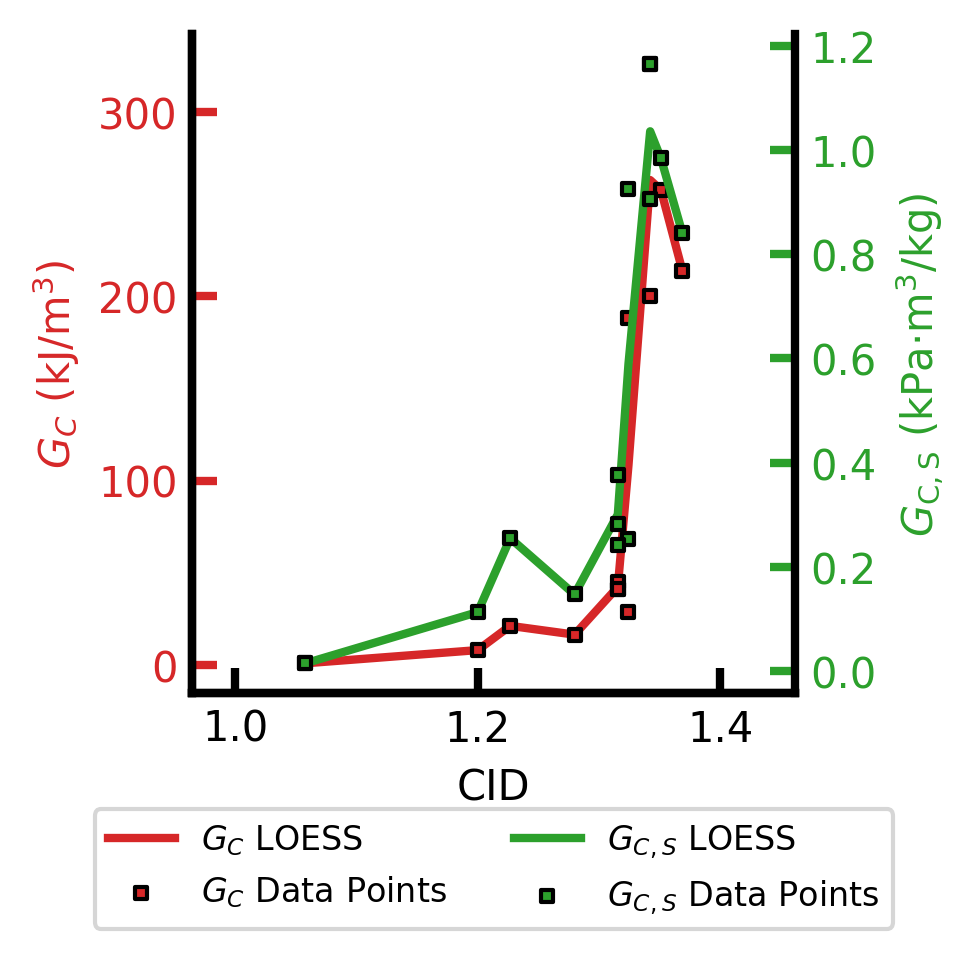

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def plot_gc_vs_cid_dual_y_axes(df):
    # Check if the values have already been converted
    if df['Toughness'].max() > 1000:  # Assuming original values are in J and will be > 1000
        # Convert Toughness values from J to kJ
        df['Toughness'] = df['Toughness'] / 1e3
    
    if df['Specific Toughness'].max() > 1000:  # Assuming original values are in appropriate units
        # Convert Specific Toughness values to kPa*m^3/kg
        df['Specific Toughness'] = df['Specific Toughness'] / 1e3

    # Preprocess data to handle duplicate x-values by averaging y-values
    df_agg_gc = df.groupby('CID')['Toughness'].mean().reset_index()
    df_agg_specific_gc = df.groupby('CID')['Specific Toughness'].mean().reset_index()

    # Create a single plot
    fig, ax1 = plt.subplots(figsize=(3.35, 3.35), dpi=300)
    # Create a second y-axis for G_{C,S}
    ax2 = ax1.twinx()

    # LOESS smoothing
    frac = 0.3  # Fraction of data used for LOESS

    lowess = sm.nonparametric.lowess
    loess_gc = lowess(df_agg_gc['Toughness'], df_agg_gc['CID'], frac=frac)
    loess_specific_gc = lowess(df_agg_specific_gc['Specific Toughness'], df_agg_specific_gc['CID'], frac=frac)

    # Plot G_C on the primary y-axis using LOESS
    ax1.plot(loess_gc[:, 0], loess_gc[:, 1], color='#d62728', label=r'$G_C$ LOESS', lw=2, zorder=1)
    ax2.plot(loess_specific_gc[:, 0], loess_specific_gc[:, 1], color='#2ca02c', label=r'$G_{C,S}$ LOESS', lw=2, zorder=2)
    ax1.scatter(df['CID'], df['Toughness'], s=9, edgecolor='black', facecolor='#d62728', marker='s', label=r'$G_C$ Data Points', zorder=3)
    ax2.scatter(df['CID'], df['Specific Toughness'], s=9, edgecolor='black', facecolor='#2ca02c', marker='s', label=r'$G_{C,S}$ Data Points', zorder=4)
    

    # Set the colors of the y-axes
    ax1.yaxis.label.set_color('#d62728')
    ax2.yaxis.label.set_color('#2ca02c')
    ax1.tick_params(axis='y', colors='#d62728', labelsize=10)
    ax2.tick_params(axis='y', colors='#2ca02c', labelsize=10)


   #Set y-axis labels
    ax1.set_ylabel(r"$G_C$ (kJ/m$^3$)", color='#d62728', fontsize=10)
    ax2.set_ylabel(r"$G_{\mathrm{C,S}}$ (kPa$\cdot$m$^3$/kg)", color='#2ca02c', fontsize=10)

    # Set x-axis label and add tick marks
    ax1.set_xlabel("CID", fontsize=10)
    ax1.tick_params(axis='x', labelsize=10, direction='in', length=6, width=2)

    # Remove the top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # ax2.spines['right'].set_visible(False)

    # Keep only the left and bottom spines and set the border color to black
    for spine in ['left', 'right', 'bottom']:
        ax1.spines[spine].set_edgecolor('black')
        ax1.spines[spine].set_linewidth(2)
        ax2.spines[spine].set_edgecolor('black')
        ax2.spines[spine].set_linewidth(2)

    # Combine the legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8)

        # Remove grid lines
    ax1.grid(False)  # Removes grid lines from the first y-axis
    ax2.grid(False)  # Removes grid lines from the second y-axis

    ax1.tick_params(axis='x', bottom=True, top=False, direction='in', length=6, width=2)
    # Set ticks on the inside and adjust their width
    ax1.tick_params(axis='y', direction='in', length=6, width=2)
    ax2.tick_params(axis='y', direction='in', length=6, width=2)

    # Calculate the current x-axis range
    x_min = df['CID'].min()
    x_max = df['CID'].max()
    x_range = x_max - x_min

    # Extend the range by a small fraction (e.g., 5% on each side)
    x_buffer = 0.30 * x_range  # 5% of the range
    ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)



    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage
# Ensure your DataFrame `merged_df` is defined and then uncomment the following line:
plot_gc_vs_cid_dual_y_axes(merged_df_2[:13])


In [11]:
import pandas as pd

# Assuming merged_df_2 is already defined
# Specify the output path
output_path = 'Data/Sample_Data_Master.csv'

# Define a dictionary to map column names to their corresponding units
units = {
    'Run Number': '',  # Placeholder unit
    'Toughness': '[J-m^(-3)]',  # Replace [unit] with the actual unit, e.g., 'MPa'
    'Sample Name': '',  # Replace [unit] if necessary
    'CID': '',  # Placeholder unit
    'Voxel Count': '',  # Placeholder unit
    'UYS': '[kPa]',  # Replace [unit] with the actual unit, e.g., 'MPa'
    'R.2%S': '[kPa]',  # Replace [unit] with the actual unit, e.g., 'MPa'
    'Net Mass': '[kg]',  # Replace [unit] with the actual unit, e.g., 'kg'
    'Effective Density': '[g-m^(-3)]',  # Replace [unit] with the actual unit, e.g., 'g/cm^3'
    'Specific UYS': '[kPa-m^3-kg^(-1)]',  # Replace [unit] with the actual unit
    'Specific R2S': '[kPa-m^3-kg^(-1)]',  # Replace [unit] with the actual unit
    'Specific Toughness': '[Pa-m^3-kg^(-1)]',  # Replace [unit] with the actual unit
}

# Remove 'Peaks' columns
filtered_df = merged_df_2.drop(columns=[col for col in merged_df_2.columns if 'Peaks' in col])

# Rename columns to include unit labels
filtered_df.rename(columns={col: f"{col} {units.get(col, '')}" for col in filtered_df.columns}, inplace=True)

# Save the modified DataFrame to a CSV file
filtered_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")


CSV file saved to Data/Sample_Data_Master.csv


In [12]:
merged_df_2

,Run Number,Toughness,Peaks_Prom_0.010,Peaks_Prom_0.010,Peaks_Prom_0.010,Peaks_Prom_0.011,Peaks_Prom_0.011,Peaks_Prom_0.011,Peaks_Prom_0.011,Peaks_Prom_0.012,...,Sample Name,CID,Voxel Count,UYS,R.2%S,Net Mass,Effective Density,Specific UYS,Specific R2S,Specific Toughness
0,4,257755.951347,7,7,7,7,7,6,6,6,...,1,1.3512,5660,4.895275e+02,471.736416,0.007075,262.037037,1.868162,1.800266,983.662288
1,5,28650.144236,8,8,8,8,8,8,8,8,...,2,1.3244,2441,3.515024e+02,299.920553,0.003051,113.009259,3.110386,2.653947,253.520326
2,6,16312.817797,21,21,21,21,21,21,21,21,...,3,1.2799,2395,2.152837e+02,144.432492,0.002994,110.879630,1.941598,1.302606,147.121864
3,7,7917.713520,7,7,7,7,7,7,7,7,...,4,1.2000,1510,1.708434e+02,137.931086,0.001888,69.907407,2.443852,1.973054,113.260008
4,8,754.640798,1,1,1,1,1,1,1,1,...,5,1.0578,1081,5.609104e+01,55.901536,0.001351,50.046296,1.120783,1.116996,15.078854
5,9,41008.277029,17,16,16,15,14,13,12,11,...,6,1.3156,3128,3.116463e+02,252.713504,0.003910,144.814815,2.152033,1.745080,283.177361
6,10,188014.823381,13,13,13,12,12,12,12,12,...,7,1.3244,4389,3.507595e+02,303.985935,0.005486,203.194444,1.726226,1.496035,925.295098
7,11,213952.251695,19,18,17,17,17,17,15,14,...,8,1.3689,5500,5.047323e+02,379.808790,0.006875,254.629630,1.982221,1.491613,840.248843
8,12,44714.334221,20,20,20,20,19,19,19,19,...,13,1.3156,2569,2.808225e+02,263.938124,0.003211,118.935185,2.361139,2.219176,375.955477
9,13,21076.756356,26,25,24,23,23,23,23,23,...,14,1.2268,1785,9.970212e+01,87.182727,0.002231,82.638889,1.206479,1.054984,255.046463
